# Residual Network (ResNet)

Adding more layers to a deep learning model should intuitively improve its performance but the practical observations are not aligned to this notion. One of the issues with deeper models can be Vanishing/exploding gradients which hampers the convergence. This can be addressed by normalized initialisation and intermediate normalization layers (BatchNorm) which enables the network to start converging for SGD with backprop. Even with using normalization, the increase in network depth leads to saturation of accuracy which eventually degrades rapidly. Unexpectedly this is not due to overfitting.

This is referred to as degradation problem. The authors solve this problem using deep residual learning framework. With skip connections, weights of multiple non-linear layers can be driven to zero to approach identity mappings.

https://openaccess.thecvf.com/content_cvpr_2016/html/He_Deep_Residual_Learning_CVPR_2016_paper.html

In [1]:
import time
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import inspect
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim.lr_scheduler import ReduceLROnPlateau

In [2]:
device= 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
# count how many trainable weights the model has
def count_parameters(model) -> None:
    total_params= sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f'Number of parameters: {total_params}')

# Define configs for different ResNet versions

Here, model_hparameters['resnet50'] = ([64,128,256,512], [3,4,6,3], 4, True) represents the hyperparameters for building a ResNet-50, where
- [64,128,256,512] -> channels in each intermediate block
- [3,4,6,3] -> number of repetition for Bottlenecks in each block
- 4 -> expansion_factor. Note that 64 turns to 256, 128 to 512. All the ResNet layers use the same expansion factor
- True -> create Bottleneck layer status. True only for ResNet-50+

In [4]:
# resnet_= (num channels, repetition, bottleneck expansion, bottleneck layer)
model_hparameters= {}
model_hparameters['resnet18'] = ([64,128,256,512], [2,2,2,2], 1, False)
model_hparameters['resnet34'] = ([64,128,256,512], [3,4,6,3], 1, False)
model_hparameters['resnet50'] = ([64,128,256,512], [3,4,6,3], 4, True)
model_hparameters['resnet101']= ([64,128,256,512], [3,4,23,3],4, True)
model_hparameters['resnet152']= ([64,128,256,512], [3,8,36,3],4, True)

# Define Bottleneck and Basic Blocks

Bottlenecks are the bulding units of ResNet architecture. A bottleneck layer is a layer that contains few nodes compared to the previous layers. It can be used to obtain a representation of the input with reduced dimensionality.

- A bottleneck consists of (conv1x1->BN->activation) -> (conv3x3->BN->activation) -> (conv1x1->BN) -> activation. Bottleneck is used to reduce the computation cost while increasing depth for layers-50, 101, and 152.
- For ResNet-18/34, Basic blocks are used instead of bottlenecks. Basic blocks are simple and effective for shallower networks but become inefficient as network depth increases.

**NOTE:** The original ResNet uses ReLU as activation function, I replaced by GELU as it is a more modern approach and suitable to avoid dead neurons (but the activation function of the network can be defined in the hyperparameters).

In [5]:
class BottleneckBlock(nn.Module):
    """
    Creates a bottleneck layer for ResNet. It uses 1x1 convolution before the 3x3 convolution
    (i.e., reduces the number of channels before applying the 3x3 convolution). The final 1x1
    convolution restores the original dimensions.
    """

    def __init__(self, in_channels, mid_channels, expansion, stride=1, activation=None) -> None:
        super(BottleneckBlock, self).__init__()
        # define the activation function -- ReLU is default in the original ResNet
        activation= nn.GELU() if activation is None else activation
        # for all ResNet-50+
        self.bottleneck= nn.Sequential(
            # conv1x1 -> BN -> activation (dimensionality reduction)
            nn.Conv2d(in_channels, mid_channels, kernel_size=1, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(mid_channels),
            activation,
            # conv3x3 -> BN -> activation (feature extraction)
            nn.Conv2d(mid_channels, mid_channels, kernel_size=3, stride=stride, padding=1, bias=False),
            nn.BatchNorm2d(mid_channels),
            activation,
            # conv1x1 -> BN (restoring dimensions)
            nn.Conv2d(mid_channels, mid_channels*expansion, kernel_size=1, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(mid_channels*expansion),
        )


    def forward(self, x):
        x= self.bottleneck(x)

        return x


In [6]:
class BasicBlock(nn.Module):
    """
    Creates a basic block layer for ResNet. It uses 3x3 convolutions in both layers (maintains the
    same number of channels throughout the block).
    """

    def __init__(self, in_channels, mid_channels, stride=1, activation=None) -> None:
        super(BasicBlock, self).__init__()
        # define the activation function -- ReLU is default in the original ResNet
        activation= nn.GELU() if activation is None else activation
        # for ResNet-18/34 (no dimensionality reduction)
        self.basic_block= nn.Sequential(
            # conv3x3 -> BN -> activation
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, stride=stride, padding=1, bias=False),
            nn.BatchNorm2d(mid_channels),
            activation,
            # conv3x3 -> BN
            nn.Conv2d(mid_channels, mid_channels, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(mid_channels),
        )


    def forward(self, x):
        x= self.basic_block(x)

        return x


# Identity vs Downsample mapping

Skip connections, which are housed in residual blocks, allow you to take the activation value from an earlier layer and pass it to a deeper layer in a network. Skip connections enable deep networks to learn the identity function. Learning the identity function allows a deeper layer to perform as well as an earlier layer, or at the very least it won't perform any worse. The result is smoother gradient flow, ensuring important features are preserved in the training process.

If **x** and the feature map size (including the number of channels) are the same, **x** can add to the feature map directly. If **x** and the feature map do not match, we apply downsample mapping (aka shortcut connection) using 1x1 convolutions where **x** and the feature map are projected to the required dimensions.

Increasing the number of filters in the ResidualBlock by a factor of 2 also comes with reducing the feature map dimensions to half. Decreasing the feature map dimensions occurs with stride=2 instead of maxpool in conv3x3 of the ResidualBlock.

In [7]:
class ResidualBlock(nn.Module):
    """
    Creates a residual layer for ResNet.
    """

    def __init__(self, in_channels, mid_channels, expansion=4, is_bottleneck=True, stride=1,
                 activation=None, dropout=0.1) -> None:
        super(ResidualBlock, self).__init__()
        # is_bottleneck=True for all ResNet-50+
        if is_bottleneck:
            self.block= BottleneckBlock(in_channels, mid_channels, expansion, stride, activation)
        else:
            self.block= BasicBlock(in_channels, mid_channels, stride, activation)
        # dropout layer for regularization
        self.dropout= nn.Dropout2d(p=dropout) if dropout> 0.0 else None
        # if dim(x)== dim(F) -> Identity function
        if in_channels== mid_channels * expansion:
            self.identity= True
        else:
            self.identity= False
            self.downsample= nn.Sequential(
                # only conv -> BN and no activation (aka shortcut connection)
                nn.Conv2d(
                    in_channels, mid_channels*expansion,
                    kernel_size=1, stride=stride, padding=0, bias=False
                ),
                nn.BatchNorm2d(mid_channels*expansion),
            )
        # define the activation function -- ReLU is default in the original ResNet
        self.activation= nn.GELU() if activation is None else activation


    def forward(self, x):
        out= self.block(x)
        if self.dropout is not None:
            out= self.dropout(out)
        # skip connection -- identity or projected map
        if self.identity:
            x= x + out
        else:
            x= self.downsample(x) + out

        return self.activation(x)


Instead of the previous layers output being passed directly onto the next block, a copy of that output is made, then that copy is passed through a residual block. This residual block will process the copied output matrix, **x** — with a 3x3 convolution, followed by BatchNorm and activation to yield a matrix **out**.

Then, **x** and **out** would be added together, element by element, to yield the output to the next layer/block. Doing this helps us ensure that any added layers in a neural network are useful for learning.

In [8]:
img= torch.randn(1, 64, 112, 112).to(device)
model= ResidualBlock(64, 64, 4, True, 2).to(device)
count_parameters(model)
print(model(img).shape)

Number of parameters: 75008
torch.Size([1, 256, 56, 56])


# Building the ResNet

The input RGB image is passed through a 7x7 Conv2d with stride=2, number of filters=64, and padding=3, followed by max pooling to reduce the feature map size by half. In the remaining architecture, only 3x3 filters are used with stride=2 in cases of reducing feature map size. Max pooling is not used.

According to the ResNet variant, create 4 Sequential ResidualBlocks, either BottleneckBlocks or BasicBlocks. All the four blocks have feature map size reduction using stride=2 except for block 1, where stride=1. This exception is because the 56x56 input remains the same throughout block 1.

After the four blocks, Average Pooling reduces the feature map to 1x1, followed by a Fully Connected Layer connecting the flattened feature map with the output classes.

In [9]:
class ResNet(nn.Module):
    """
    Initializes the ResNet architecture based on the provided variant.
    """

    def __init__(self, resnet_type, in_channels, num_classes, activation=None, dropout=0.1) -> None:
        super(ResNet, self).__init__()
        # define the channels and repeatition lists along with expansion factor and stride
        channels= resnet_type[0]
        repetitions= resnet_type[1]
        expansion= resnet_type[2]
        is_bottleneck= resnet_type[3]
        # define the activation function -- ReLU is default in the original ResNet
        activation= nn.GELU() if activation is None else activation

        self.conv_in= nn.Sequential(
            nn.Conv2d(in_channels, out_channels=64, kernel_size=7, stride=2, padding=3, bias=False),
            nn.BatchNorm2d(64),
            activation,
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
        )
        self.block1= self.residual_stack(
            64, channels[0], repetitions[0], expansion, is_bottleneck, stride=1,
            activation=activation, dropout=dropout
        )
        self.block2= self.residual_stack(
            channels[0]*expansion, channels[1], repetitions[1], expansion, is_bottleneck, stride=2,
            activation=activation, dropout=dropout
        )
        self.block3= self.residual_stack(
            channels[1]*expansion, channels[2], repetitions[2], expansion, is_bottleneck, stride=2,
            activation=activation, dropout=dropout
        )
        self.block4= self.residual_stack(
            channels[2]*expansion, channels[3], repetitions[3], expansion, is_bottleneck, stride=2,
            activation=activation, dropout=dropout
        )
        self.average_pool= nn.AdaptiveAvgPool2d(output_size=(1, 1))
        self.fc_out= nn.Linear(channels[3]*expansion, num_classes)

        # initialize parameters -- Xavier is more suitable for GELU
        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None: nn.init.zeros_(m.bias)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1.0)
                nn.init.constant_(m.bias, 0.0)


    def residual_stack(
        self, in_channels, mid_channels, repetitions, expansion, is_bottleneck, stride,
        activation, dropout
    ):
        """
        Create a sequential stack of residual blocks.
        """
        layers= nn.Sequential(
            ResidualBlock(
                in_channels, mid_channels, expansion, is_bottleneck, stride, activation, dropout
            ),
            *[ResidualBlock(
                mid_channels*expansion, mid_channels, expansion, is_bottleneck, stride=1,
                activation=activation, dropout=dropout
            ) for _ in range(1, repetitions)],
        )
        return layers


    def forward(self, x):
        x= self.conv_in(x)
        x= self.block1(x)
        x= self.block2(x)
        x= self.block3(x)
        x= self.block4(x)
        x= torch.flatten(self.average_pool(x), start_dim=1)

        # softmax (if needed) is applied externally
        return self.fc_out(x)


**ResNet with GELU Recommendation:** Use nn.init.xavier_uniform_. Uniform initialization often provides more stable training in practice, especially for networks with batch normalization like ResNet. Uniform initialization avoids rare large values that may occur with normal initialization and provides consistent variance across layers.

In [10]:
img= torch.randn(1, 3, 224, 224).to(device)
model= ResNet(model_hparameters['resnet50'], in_channels=3, num_classes=1000, dropout=0.1).to(device)
count_parameters(model)
print(model(img).shape)

model

Number of parameters: 25557032
torch.Size([1, 1000])


ResNet(
  (conv_in): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): GELU(approximate='none')
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (block1): Sequential(
    (0): ResidualBlock(
      (block): BottleneckBlock(
        (bottleneck): Sequential(
          (0): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): GELU(approximate='none')
          (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (5): GELU(approximate='none')
          (6): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (7): BatchNorm2d(256, eps=1e

In [ ]:
import torchvision.models as models
from torchvision.models import ResNet50_Weights

tvis_model= models.resnet50(weights=ResNet50_Weights.IMAGENET1K_V1).to(device)
count_parameters(tvis_model)
img= torch.randn(1, 3, 224, 224).to(device)
print(tvis_model(img).shape)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 143MB/s]


Number of parameters: 25557032
torch.Size([1, 1000])


# Training the ResNet model from scratch

In [ ]:
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms

In [ ]:
# data preparation -- define transformations for the dataset
transform= transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.2023, 0.1994, 0.2010]), # CIFAR-10 stats
])

# load the CIFAR-10 dataset
train_dataset= datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR10(root='./data', train=False,download=True, transform=transform)

# create data loaders
train_size= int(0.9 * len(train_dataset))
val_size  = len(train_dataset) - train_size
train_dataset, val_dataset= random_split(train_dataset, [train_size, val_size])

batch_size= 128
train_loader= DataLoader(train_dataset,batch_size=batch_size, shuffle=True)
val_loader  = DataLoader(val_dataset,  batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

100%|██████████| 170M/170M [00:01<00:00, 104MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [ ]:
len(train_loader), len(val_loader)

(352, 40)

# Trainer Function

TODO:
- Data augmentation for training.
- Logging Learning Rate.
- Early Stopping: based on validation loss to prevent overfitting.

In [ ]:
def trainer(model, train_loader, val_loader, optimizer, criterion, scheduler, epochs,
            device, eval_interval=1, verbose=False):

    tr_loss_hist= []
    vl_loss_hist= []

    # --- training loop ---
    for epoch in range(epochs):
        model.train()
        batch_loss= []
        start= time.time()

        # --- training steps ---
        # iterating over all batches
        for step, (images, labels) in enumerate(train_loader):
            # --- minibatch construction ---
            images= images.to(device, non_blocking=True)
            labels= labels.to(device, non_blocking=True)

            # --- forward pass and get loss ---
            logits= model(images)
            loss= criterion(logits, labels)
            batch_loss.append(loss.item())

            # --- backward pass to calculate the gradients ---
            optimizer.zero_grad()
            loss.backward()

            # --- update the parameters using the gradient ---
            optimizer.step()

        # --- evaluation and track stats ---
        tr_loss_hist.append(np.mean(batch_loss))

        if epoch% eval_interval== 0 or epoch== epochs-1:
            model.eval()
            val_loss= []
            with torch.no_grad():
                for images, labels in val_loader:
                    images, labels= images.to(device), labels.to(device)
                    logits= model(images)
                    loss_v= criterion(logits, labels)
                    val_loss.append(loss_v.item())

            val_loss= np.mean(val_loss)
            end= time.time()
            dt= end - start

            if verbose:
                print(f"Epoch: {epoch} | Train Loss: {tr_loss_hist[-1]:.4f} | "
                      f"Val Loss: {val_loss:.4f} | dt/epoch: {dt*1000:.2f}ms")

            # for decreasing learning rate -- the ReduceLROnPlateau is designed to be used per epoch
            scheduler.step(val_loss)

        vl_loss_hist.append(val_loss)

    return tr_loss_hist, vl_loss_hist


In [ ]:
def evaluate_model(model, test_loader, device, verbose=False):
    model.eval()
    correct= 0
    total= 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels= images.to(device), labels.to(device)
            logits= model(images)
            y_pred= torch.argmax(logits, dim=1)
            correct += (y_pred == labels).sum().item()
            total += labels.size(0)

    acc= correct / total
    if verbose:
        print(f"Accuracy: {(acc * 100):.2f}%")

    return acc


In [ ]:
def plot_losses(train_loss, valid_loss):
    # plot training and validation losses
    plt.plot(train_loss, label='Train Loss')
    plt.plot(valid_loss, label='Validation Loss')
    plt.title('Losses')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()

# Training setup using TF32 and Fused AdamW

In [ ]:
use_fused= False

if device== 'cuda': # TF32 computationally more efficient (slightly the same precision of FP32)
    torch.set_float32_matmul_precision('high')
    # create AdamW optimizer and use the fused version of it is available
    fused_available= 'fused' in inspect.signature(torch.optim.AdamW).parameters
    # fused is a lot faster when it is available and when running on cuda
    use_fused= fused_available

# --- ResNet-50 ---
in_channels= 3
num_classes= 10

model= ResNet(model_hparameters['resnet50'], in_channels, num_classes, dropout=0.1).to(device)
count_parameters(model)


# train_loader has size 352, so 20 epochs have 7,040 steps
epochs= 20
learning_rate= 1e-3

optimizer= torch.optim.AdamW(
    model.parameters(), lr=learning_rate, betas=(0.9, 0.999), weight_decay=1e-4,
    fused=use_fused
)
print(f"Using fused AdamW: {use_fused}")
criterion= nn.CrossEntropyLoss()
# for decreasing learning rate -- the ReduceLROnPlateau is designed to be used per epoch
scheduler= ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, min_lr=1e-6)

Number of parameters: 23528522
Using fused AdamW: True


In [ ]:
tr_loss, vl_loss= trainer(model, train_loader, val_loader, optimizer, criterion, scheduler,
                          epochs, device, verbose=True)

Epoch: 0 | Train Loss: 1.6132 | Val Loss: 1.6342 | dt/epoch: 90975.75ms
Epoch: 1 | Train Loss: 1.1005 | Val Loss: 1.2328 | dt/epoch: 91044.69ms
Epoch: 2 | Train Loss: 0.8910 | Val Loss: 1.2778 | dt/epoch: 90954.17ms
Epoch: 3 | Train Loss: 0.7475 | Val Loss: 0.8094 | dt/epoch: 90959.45ms
Epoch: 4 | Train Loss: 0.6300 | Val Loss: 0.7262 | dt/epoch: 91404.87ms
Epoch: 5 | Train Loss: 0.5440 | Val Loss: 0.6547 | dt/epoch: 90927.57ms
Epoch: 6 | Train Loss: 0.4887 | Val Loss: 0.7015 | dt/epoch: 91108.82ms
Epoch: 7 | Train Loss: 0.4459 | Val Loss: 0.5306 | dt/epoch: 91176.32ms
Epoch: 8 | Train Loss: 0.3914 | Val Loss: 0.5016 | dt/epoch: 91467.60ms
Epoch: 9 | Train Loss: 0.3507 | Val Loss: 0.4961 | dt/epoch: 91552.12ms
Epoch: 10 | Train Loss: 0.3101 | Val Loss: 0.5003 | dt/epoch: 91378.08ms
Epoch: 11 | Train Loss: 0.2891 | Val Loss: 0.4955 | dt/epoch: 90732.95ms
Epoch: 12 | Train Loss: 0.2589 | Val Loss: 0.4757 | dt/epoch: 90976.78ms
Epoch: 13 | Train Loss: 0.2261 | Val Loss: 0.4714 | dt/epoch:

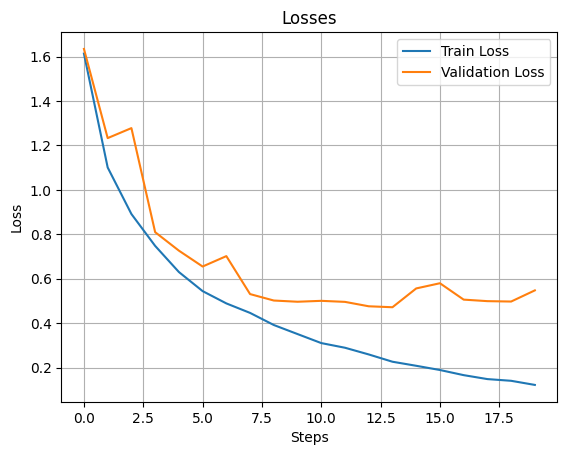

In [ ]:
# plot
plot_losses(tr_loss, vl_loss)

**NOTE:** In this case, the x-axis accounts for epochs, not steps.

In [ ]:
vit_acc= evaluate_model(model, test_loader, device, verbose=True)

Accuracy: 85.00%


In [ ]:
# https://heartbeat.comet.ml/resnet-how-one-paper-changed-deep-learning-forever-2256cf09fa9a
# https://medium.com/@karuneshu21/resnet-paper-walkthrough-b7f3bdba55f0
# https://medium.com/@karuneshu21/how-to-resnet-in-pytorch-9acb01f36cf5